In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import calendar
import warnings
from textblob import TextBlob

In [2]:
warnings.filterwarnings('ignore')

### Task 1

Load the four files containing the invididually generated tweets and merge the resulting dataframes.

In [3]:
edf1 = pd.read_csv('2020_dec_09_e_c.csv')
edf2 = pd.read_csv('2020_dec_08_e_c.csv')

In [4]:
wdf1 = pd.read_csv('2020-dec-09-w-p.csv')
wdf2 = pd.read_csv('2020-dec-10-w-p.csv')

Check size of each dataset

In [5]:
res = []
df_lst = [edf1, edf2, wdf1, wdf2]
for lst in df_lst:
    res.append(len(lst))
res

[5322, 5310, 7000, 7000]

In [6]:
sum(res)

24632

In [7]:
df = pd.concat([edf1, edf2, wdf1, wdf2])

In [8]:
df.shape

(24632, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24632 entries, 0 to 6999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TweetText       24618 non-null  object
 1   SentBy          24632 non-null  object
 2   SenderLocation  16918 non-null  object
 3   SendDate        24632 non-null  object
dtypes: object(4)
memory usage: 962.2+ KB


Convert SendDate to datetime object and TweetText to string

In [10]:
df['SendDate'] = pd.to_datetime(df['SendDate'])
df['TweetText'] = df['TweetText'].astype(str)

In [11]:
df.dtypes

TweetText                 object
SentBy                    object
SenderLocation            object
SendDate          datetime64[ns]
dtype: object

Group the tweets by date and determine the number of tweets in the dataset for each unique date.

In [12]:
dates = df.groupby([df['SendDate'].dt.date]).count()
dates['TweetText']

SendDate
2020-12-08    4542
2020-12-09    6961
2020-12-10    6799
2020-12-11    6330
Name: TweetText, dtype: int64

Date with most tweets

In [13]:
dates.TweetText.idxmax()

datetime.date(2020, 12, 9)

Date with least tweets

In [14]:
dates.TweetText.idxmin()

datetime.date(2020, 12, 8)

Generate the sentiment for each tweet and determine which sentiments are dominant.

In [15]:
def cleanup(tweet):
    return ' '.join(
        re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", 
        " ", 
        tweet
        ).split()
    )

In [16]:
def polarity_df(df_col): 
    lst = []
    sent_lst = []
    for i in df_col:
        lst.append(TextBlob(i))
    for i in lst:
        sent_lst.append(i.sentiment[0])
    return sent_lst

def subjectivity_df(df_col): 
    lst = []
    sent_lst = []
    for i in df_col:
        lst.append(TextBlob(i))
    for i in lst:
        sent_lst.append(i.sentiment[1])
    return sent_lst

In [17]:
df['Sentiments'] = polarity_df(df.TweetText)

In [18]:
df.head()

,TweetText,SentBy,SenderLocation,SendDate,Sentiments
0,New Podcast is up on Rat Salad Review Network!...,rat_review,Youtube,2020-12-09 15:02:00,0.170455
1,"Ugh, I’m too lazy to make lunch, I’ll buy a sa...",comic_canary,"Baltimore, MD",2020-12-09 15:02:00,-0.250000
2,Caught off guard by how good this salad is. Ne...,rastafaryeye,"London, England",2020-12-09 15:02:00,0.558333
3,You have to try our Pomegranate and Fresh Mozz...,RenaeMcconnell,"Portsmouth, VA",2020-12-09 15:02:00,0.200000
4,@_hungry_otter_ Tysm for this ga! @Heavenly_Sa...,tyongyoshi,Taeyong’s aquarium,2020-12-09 15:02:00,0.000000


In [19]:
def sentiments(col):
    """Returns the total number of positive, neutral, and negative
    sentiments for a given list of polarity values, and returns the 
    most dominant sentiment.
    """
    neg = len([i for i in col if i <= -0.5])
    print('The number of negative sentiments is', neg)
    neu = len([i for i in col if i > -0.5 and i < 0.5])
    print('The number of neutral sentiments is', neu)
    pos = len([i for i in col if i >= 0.5])
    print('The number of positive sentiments is', pos)
    dom = max(neg, neu, pos)
    def helper(dom):
        if dom == neg:
            return 'negative'
        if dom == neu:
            return 'neutral'
        if dom == pos:
            return 'positive'
    print('The dominant sentiment is', helper(dom), 'with', dom, 'returns.')

In [20]:
sentiments(df.Sentiments)

The number of negative sentiments is 984
The number of neutral sentiments is 20302
The number of positive sentiments is 3346
The dominant sentiment is neutral with 20302 returns.


Extract tweets with subjectivity >= 0.4 and analyse the dominant sentiment among this subset of tweets.

In [21]:
df['Subjectivity'] = subjectivity_df(df.TweetText)

In [22]:
df.head()

,TweetText,SentBy,SenderLocation,SendDate,Sentiments,Subjectivity
0,New Podcast is up on Rat Salad Review Network!...,rat_review,Youtube,2020-12-09 15:02:00,0.170455,0.454545
1,"Ugh, I’m too lazy to make lunch, I’ll buy a sa...",comic_canary,"Baltimore, MD",2020-12-09 15:02:00,-0.250000,1.000000
2,Caught off guard by how good this salad is. Ne...,rastafaryeye,"London, England",2020-12-09 15:02:00,0.558333,0.733333
3,You have to try our Pomegranate and Fresh Mozz...,RenaeMcconnell,"Portsmouth, VA",2020-12-09 15:02:00,0.200000,0.416667
4,@_hungry_otter_ Tysm for this ga! @Heavenly_Sa...,tyongyoshi,Taeyong’s aquarium,2020-12-09 15:02:00,0.000000,0.000000


In [23]:
df.dtypes

TweetText                 object
SentBy                    object
SenderLocation            object
SendDate          datetime64[ns]
Sentiments               float64
Subjectivity             float64
dtype: object

In [24]:
subjective_df = df[df.Subjectivity >= 0.4]

In [25]:
subjective_df.shape

(10481, 6)

In [26]:
sentiments(subjective_df.Sentiments)

The number of negative sentiments is 979
The number of neutral sentiments is 7006
The number of positive sentiments is 2496
The dominant sentiment is neutral with 7006 returns.


The dominant sentiment is still neutral, with negative sentiments still being the least popular.

Which locations have the best and worst sentiments towards fruits and vegetables?

In [27]:
locs = df.groupby('SenderLocation').mean()

Location with the best sentiments

In [28]:
locs.Sentiments.idxmax()

' (via Portland) '

Location with the worse sentiments

In [29]:
locs.Sentiments.idxmin()

'229'

### Task 2

#### Explore, Prepare Data

In [30]:
t2 = pd.read_csv('COMP4621_SalesRecords05.csv')

In [31]:
t2.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

Region: the geographical region that corresponds to the country where the order was made  
Country: the country where the order was made  
Item Type: the type of item ordered  
Sales Channel: whether the order order was made offline or online  
Order Priority: priority of the order; high, medium, low, critical  
Order Date: date on which the order was placed  
Order ID: unique order ID number  
Ship Date: date when the item was shipped  
Units Sold: the total number of units sold per order  
Unit Price: price per unit per order  
Unit Cost: the price at which the unit was bought by the business  
Total Revenue: the units sold multiplied by the unit price per order  
Total Cost: the units sold multipled by the unit cost per order  
Total Profit: total revenue minus total cost  

In [32]:
t2.dtypes

Region             object
Country            object
Item Type          object
Sales Channel      object
Order Priority     object
Order Date         object
Order ID          float64
Ship Date          object
Units Sold        float64
Unit Price        float64
Unit Cost         float64
Total Revenue     float64
Total Cost        float64
Total Profit      float64
dtype: object

In [33]:
t2['Order Date'] = pd.to_datetime(t2['Order Date'])
t2['Ship Date'] = pd.to_datetime(t2['Ship Date'])

In [34]:
t2_cat_cols = ['Region', 'Country', 'Item Type', 'Sales Channel', 
              'Order Priority']
for i in t2_cat_cols:
    t2[i] = t2[i].astype('category')

In [35]:
t2.dtypes

Region                  category
Country                 category
Item Type               category
Sales Channel           category
Order Priority          category
Order Date        datetime64[ns]
Order ID                 float64
Ship Date         datetime64[ns]
Units Sold               float64
Unit Price               float64
Unit Cost                float64
Total Revenue            float64
Total Cost               float64
Total Profit             float64
dtype: object

In [36]:
for i in t2.columns:
    print(t2[i].value_counts(), '\n')  

Sub-Saharan Africa                   52671
Europe                               52657
Asia                                 29494
Middle East and North Africa         25318
Central America and the Caribbean    22182
Australia and Oceania                16383
North America                         4433
Job Lane                                 3
Name: Region, dtype: int64 

San Marino      1192
Panama          1188
Brunei          1186
Cyprus          1175
Mexico          1172
                ... 
Uzbekistan      1035
Mozambique      1033
Nauru           1031
Vatican City    1022
Job Lane          53
Name: Country, Length: 186, dtype: int64 

Snacks             17043
Fruits             17013
Household          16984
Personal Care      16979
Baby Food          16955
Meat               16926
Clothes            16916
Cosmetics          16914
Beverages          16894
Office Supplies    16865
Cereal             16856
Vegetables         16795
Name: Item Type, dtype: int64 

Online     101607
Off

In [37]:
t2.isnull().sum()

Region             177
Country            178
Item Type          178
Sales Channel      178
Order Priority       0
Order Date        2034
Order ID          1538
Ship Date         1538
Units Sold        1713
Unit Price        4551
Unit Cost         3920
Total Revenue     4329
Total Cost        3698
Total Profit      3244
dtype: int64

In [38]:
t2.shape

(203318, 14)

In [39]:
t2.replace('', np.NaN)

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Australia and Oceania,Tonga,Clothes,Offline,C,2011-07-03,141493451.0,2011-08-13,9911.0,109.28,35.84,1083074.08,355210.24,727863.84
1,Sub-Saharan Africa,Cameroon,Personal Care,Offline,M,2016-08-12,339886367.0,2016-09-28,8784.0,81.73,56.67,717916.32,497789.28,220127.04
2,Australia and Oceania,East Timor,Meat,Online,L,2015-09-19,669634568.0,2015-10-03,8604.0,421.89,364.69,3629941.56,3137792.76,492148.80
3,Middle East and North Africa,Lebanon,Meat,Online,H,2013-09-15,733911883.0,2013-10-23,9690.0,421.89,364.69,4088114.10,3533846.10,554268.00
4,Australia and Oceania,East Timor,Vegetables,Online,M,2016-07-21,656204640.0,2016-08-09,4390.0,154.06,90.93,676323.40,399182.70,277140.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203313,Europe,Monaco,Snacks,Online,H,2017-04-15,430434310.0,2017-05-11,3932.0,152.58,97.44,599944.56,383134.08,216810.48
203314,Europe,Romania,Vegetables,Offline,H,2013-05-28,698439347.0,2013-07-10,2579.0,154.06,90.93,397320.74,234508.47,162812.27
203315,Sub-Saharan Africa,Rwanda,Beverages,Online,H,2013-07-24,665817248.0,2013-08-12,8975.0,47.45,31.79,425863.75,285315.25,140548.50
203316,Sub-Saharan Africa,Cote d'Ivoire,Meat,Online,M,2014-04-04,231054341.0,2014-05-22,2969.0,421.89,364.69,1252591.41,1082764.61,169826.80


If the location cannot be identified, we cannot use that record to make caluculations regarding optimal markets.

In [40]:
t2 = t2.dropna(subset=['Country' and 'Region'])

In [41]:
t2.shape

(203141, 14)

'Job Lane' is a fictitious region.

In [42]:
t2 = t2[t2.Region != 'Job Lane']

In [43]:
t2.shape

(203138, 14)

#### Analysis

i. What is the average spend on vegetables and fruits in each country or region?

In [44]:
t2_fv = t2[(t2['Item Type'] == 'Fruits') | 
           (t2['Item Type'] == 'Vegetables')]

In [45]:
t2_fv['Item Type'].value_counts()

Fruits             17011
Vegetables         16795
Snacks                 0
Personal Care          0
Office Supplies        0
Meat                   0
Household              0
Cosmetics              0
Clothes                0
Cereal                 0
Beverages              0
Baby Food              0
Name: Item Type, dtype: int64

In [46]:
fv_ctry_mean = t2_fv.groupby('Country').mean()

In [47]:
fv_ctry_mean['Total Revenue']

Country
Afghanistan     378616.405920
Albania         378755.506287
Algeria         380811.035798
Andorra         380777.309779
Angola          365031.809891
                    ...      
Vatican City    371526.919103
Vietnam         423737.663164
Yemen           440766.752000
Zambia          371364.123256
Zimbabwe        447606.005235
Name: Total Revenue, Length: 186, dtype: float64

In [48]:
fv_region_mean = t2_fv.groupby('Region').mean()

In [49]:
fv_region_mean['Total Revenue']

Region
Asia                                 404961.180906
Australia and Oceania                410058.731026
Central America and the Caribbean    405766.996432
Europe                               406814.352638
Job Lane                                       NaN
Middle East and North Africa         394452.487439
North America                        381681.031889
Sub-Saharan Africa                   404084.024677
Name: Total Revenue, dtype: float64

Which region or country has the highest spending on fruits and vegetables?

In [50]:
fv_ctry_sum = t2_fv.groupby('Country').sum()

In [51]:
fv_ctry_sum[fv_ctry_sum['Total Revenue'] 
            == fv_ctry_sum['Total Revenue'].max()]['Total Revenue']

Country
Namibia    91667247.39
Name: Total Revenue, dtype: float64

In [52]:
fv_region_sum = t2_fv.groupby('Region').sum()

In [53]:
fv_region_sum[fv_region_sum['Total Revenue'] 
            == fv_region_sum['Total Revenue'].max()]['Total Revenue']

Region
Sub-Saharan Africa    3.520784e+09
Name: Total Revenue, dtype: float64

What country or region consumes the most fruits and vegetables?

In [54]:
fv_ctry_sum[fv_ctry_sum['Units Sold'] 
            == fv_ctry_sum['Units Sold'].max()]['Units Sold']

Country
Namibia    1094491.0
Name: Units Sold, dtype: float64

In [55]:
fv_region_sum[fv_region_sum['Units Sold'] 
            == fv_region_sum['Units Sold'].max()]['Units Sold']

Region
Sub-Saharan Africa    43858743.0
Name: Units Sold, dtype: float64

What is the average profit from the sale of fruits and vegetables in each country or region?

In [56]:
fv_ctry_mean['Total Profit']

Country
Afghanistan     151061.613085
Albania         151291.293234
Algeria         152516.400638
Andorra         152163.817072
Angola          145979.821202
                    ...      
Vatican City    147687.297808
Vietnam         170486.947119
Yemen           177670.414550
Zambia          148669.380988
Zimbabwe        179798.344235
Name: Total Profit, Length: 186, dtype: float64

In [57]:
fv_region_mean['Total Profit']

Region
Asia                                 162507.616886
Australia and Oceania                164193.222416
Central America and the Caribbean    162880.021991
Europe                               163312.314651
Job Lane                                       NaN
Middle East and North Africa         157980.047358
North America                        153102.801148
Sub-Saharan Africa                   162029.790867
Name: Total Profit, dtype: float64

What has been the total revenue from fruits and vegetables for each year since 2012?

In [58]:
fv_2012 = t2_fv[(t2_fv['Ship Date'].dt.year >= 2012)]

In [59]:
fv_2012['Ship Date'].dt.year.value_counts()

2014    4532
2016    4501
2013    4476
2015    4393
2012    4376
2017    2838
Name: Ship Date, dtype: int64

In [60]:
fv_2012['Ship Year'] = fv_2012['Ship Date'].dt.year

In [61]:
tot_rev_by_year = fv_2012.groupby('Ship Year').sum()

In [62]:
tot_rev_by_year['Total Revenue']

Ship Year
2012    1.720124e+09
2013    1.761361e+09
2014    1.829923e+09
2015    1.720620e+09
2016    1.710579e+09
2017    1.140214e+09
Name: Total Revenue, dtype: float64

In [63]:
tot_rev_by_year

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
Ship Year,,,,,,,
2012,2.456210e+12,21622955.0,348688.14,209250.77,1.720124e+09,1.032559e+09,6.910712e+08
2013,2.420074e+12,22273701.0,352660.47,212245.64,1.761361e+09,1.059634e+09,7.087501e+08
2014,2.510134e+12,22330494.0,371596.20,223168.04,1.829923e+09,1.100395e+09,7.378697e+08
2015,2.388583e+12,22013496.0,342095.87,205973.41,1.720620e+09,1.035670e+09,6.922686e+08
2016,2.458522e+12,22248130.0,345433.07,207462.05,1.710579e+09,1.028962e+09,6.867534e+08
2017,1.553074e+12,14110982.0,227457.54,136605.52,1.140214e+09,6.850910e+08,4.589769e+08


Text(0.5, 1.0, 'Total Revenue from Fruits & Vegetables by Year Since 2012')

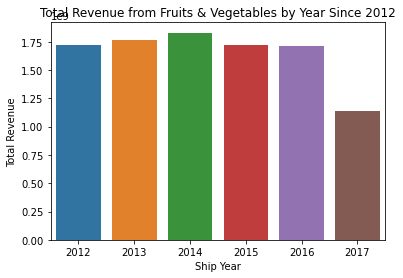

In [64]:
sns.barplot(x = tot_rev_by_year.index,
            y = 'Total Revenue',
            data = tot_rev_by_year).set_title('Total Revenue from Fruits & Vegetables by Year Since 2012')

What is the dominant sales channel for fruits and vegetables?

In [65]:
t2_fv['Sales Channel'].value_counts()

Offline    16954
Online     16852
Name: Sales Channel, dtype: int64

In [66]:
t2_fv['Sales Channel'].value_counts().idxmax()

'Offline'

What is the average units sold for each item in the dataset (not just fruits and vegetables) by country or region?

In [67]:
t2_items_ctry = t2.groupby(['Country', 'Item Type']).mean()
t2_items_ctry['Units Sold']

Country      Item Type      
Afghanistan  Baby Food          4554.103774
             Beverages          4894.988372
             Cereal             4858.835294
             Clothes            5337.021978
             Cosmetics          5284.195876
                                   ...     
Zimbabwe     Meat               5177.391304
             Office Supplies    4925.098901
             Personal Care      4987.259615
             Snacks             4589.831683
             Vegetables         5425.818182
Name: Units Sold, Length: 2232, dtype: float64

In [68]:
t2_items_reg = t2.groupby(['Region', 'Item Type']).mean()
t2_items_reg['Units Sold']

Region              Item Type      
Asia                Baby Food          4961.183750
                    Beverages          5047.786885
                    Cereal             4972.290749
                    Clothes            4963.226749
                    Cosmetics          5013.371487
                                          ...     
Sub-Saharan Africa  Meat               4961.267800
                    Office Supplies    5003.465286
                    Personal Care      4979.729989
                    Snacks             5032.169914
                    Vegetables         4945.841400
Name: Units Sold, Length: 96, dtype: float64

Is fruits and vegetables units sold above the overall mean for units sold?

In [69]:
t2_fv['Units Sold'].mean() > t2['Units Sold'].mean()

False

In [70]:

t2_fv['Order Date']

4        2016-07-21
10       2013-02-04
12       2016-08-07
200      2014-10-20
205      2010-03-21
            ...    
203281   2010-04-27
203284   2011-02-15
203290   2015-12-18
203293   2010-03-02
203314   2013-05-28
Name: Order Date, Length: 33806, dtype: datetime64[ns]

In [71]:
t2_fv['Order Month'] = t2_fv['Order Date'].dt.month

In [72]:
season = {
    1.0: 'Winter',
    2.0: 'Spring',
    3.0: 'Spring',
    4.0: 'Spring',
    5.0: 'Summer',
    6.0: 'Summer',
    7.0: 'Summer',
    8.0: 'Autumn',
    9.0: 'Autumn',
    10.0: 'Autumn',
    11.0: 'Winter',
    12.0: 'Winter',
}

In [73]:
t2_fv['Order Season'] = t2_fv['Order Month'].map(season)

In [74]:
t2_fv[['Country', 'Order Date', 'Order Season']]

,Country,Order Date,Order Season
4,East Timor,2016-07-21,Summer
10,Dominica,2013-02-04,Spring
12,Germany,2016-08-07,Autumn
200,Netherlands,2014-10-20,Autumn
205,Bahrain,2010-03-21,Spring
...,...,...,...
203281,Belarus,2010-04-27,Spring
203284,Morocco,2011-02-15,Spring
203290,Democratic Republic of the Congo,2015-12-18,Winter
203293,El Salvador,2010-03-02,Spring


In [75]:
t2_fv_season = t2_fv.groupby('Order Season').sum()

Text(0.5, 1.0, 'Spending on Fruits & Vegetables by Season')

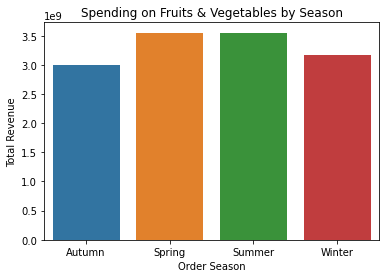

In [76]:
sns.barplot(x = t2_fv_season.index,
            y = 'Total Revenue',
            data = t2_fv_season).set_title('Spending on Fruits & Vegetables by Season')

In [77]:
t2_fv_season['Total Revenue'].idxmax()

'Spring'

#### Recommendations

a. When is the best time to open the healthy-foods franchise given that their primary products are made from salad along with other fruits and vegetables?

According to the results found above, Spring is the season in which the most revenue is earned from selling fruits and vegetables.

In [78]:
t2_fv_season['Total Profit'].idxmax()

'Spring'

It is also true that the season in which the most profit is earned is Spring.

b. Which country/region provides the best opportunity for profit maximization based on the data analysed?

In [79]:
fv_ctry_mean['Total Profit'].idxmax()

'Kiribati'

In [80]:
fv_region_mean['Total Profit'].idxmax()

'Australia and Oceania'

According to the data, the country and region that provide the best opportunities for profit maximization are Kiribati and Australia and Oceania respectively.

c. Based on the current sentiments and opportunity for maximizing profits, is this investment a good option at this current time?

In [81]:
sentiments(df.Sentiments)

The number of negative sentiments is 984
The number of neutral sentiments is 20302
The number of positive sentiments is 3346
The dominant sentiment is neutral with 20302 returns.


In [82]:
sentiments(subjective_df.Sentiments)

The number of negative sentiments is 979
The number of neutral sentiments is 7006
The number of positive sentiments is 2496
The dominant sentiment is neutral with 7006 returns.


In terms of sentiments, the dominant sentiment for both all tweets, and subjective tweets, is neutral. Positive sentiments towards fruits and vegetables are also higher in both cases than negative sentiments. 

Considering the season with the highest total revenues and profits is Spring, the ideal time to invest would be then. However, we can begin preparing now in December, to be able to be on the market by Spring to maximize our earnings potential.

d. Are there any limitations, ethical issues to declare in relation to your results or analysis?

In terms of sentiments as analysed by tweets, it is possible that the sentiments towards fruits and vegetables may vary over time, and that our four day scrape during the Winter may not be reflective of sentiments during other seasons. 

Seasons are also dependent on hemisphere; I conducted this analysis using the seasons as defined in the Northern Hemisphere. 

Ethically, targetting areas that provide the most profit may divert produce away from regions that may actually have food shortages. 